# General concepts

Some data has natural features:
 - trend - linear, polynomial, etc.
 - seasonality - hourly, daily, monthly, etc and combinations of those
 
Examples:
 - electricity consumption: https://www.eia.gov/todayinenergy/detail.php?id=42915
 - ice cream sales: https://fred.stlouisfed.org/graph/?id=IPN31152N, 
 - heart rate
 - database size

In the beginning time series analysis included simple steps:
 - remove trend
 - remove seasonality
 - forecast the rest nose
 - forecast total = trend + seasonality + noise forecast
 
ARIMA combines these ideas in one model

# Setup

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # using Least Squares estimation instead of scikit Maximum Likelihood
import matplotlib.pylab as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.rcParams['figure.figsize'] = [15, 8] # global var for pics size

# Data: US airlines passenger data

In [2]:
airline = pd.read_csv("airline.csv").set_index('month')/10**6
airline.head()

,total
month,
2009-01,56.900323
2009-02,54.093004
2009-03,66.043684
2009-04,64.877586
2009-05,64.757794


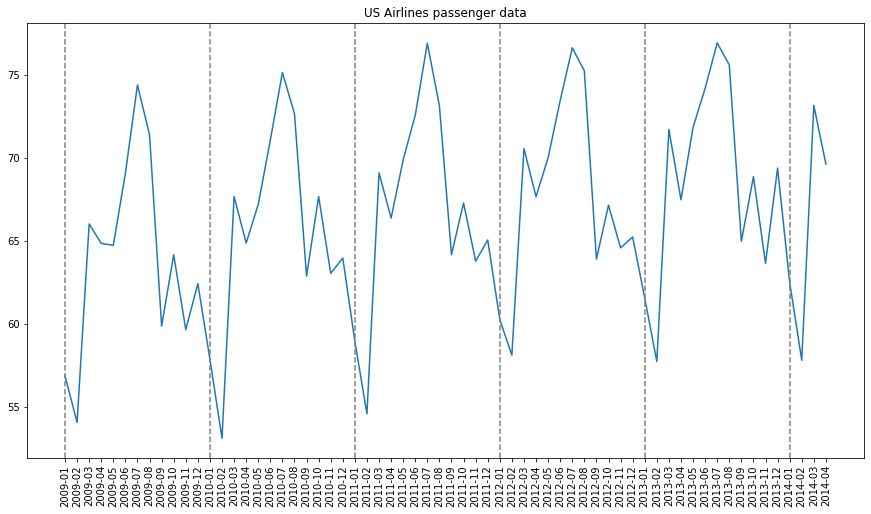

In [3]:
plt.title('US Airlines passenger data')
plt.plot(airline)
locs, labels = plt.xticks(rotation=90)
for i in range(6):
    plt.axvline(i*12, color='grey', linestyle='--')

# Remove trend with linear regression

In [4]:
y = airline.total.values
x = list(range(len(airline)))
model = sm.OLS(y, sm.add_constant(x)).fit()
print(model.summary())
model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.853
Date:                Sun, 11 Oct 2020   Prob (F-statistic):             0.0313
Time:                        17:08:36   Log-Likelihood:                -202.51
No. Observations:                  64   AIC:                             409.0
Df Residuals:                      62   BIC:                             413.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.7977      1.438     44.366      0.0

array([63.79770339,  0.08675166])

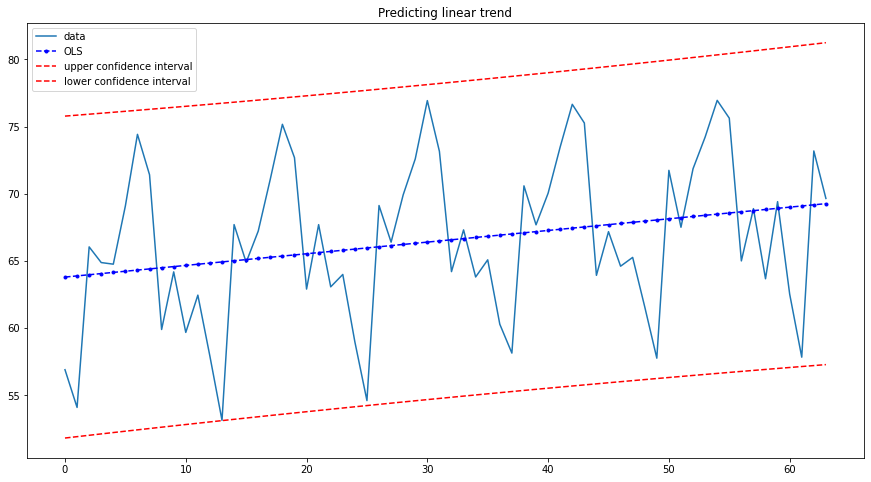

In [5]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(model)

fig, ax = plt.subplots()
plt.title('Predicting linear trend')

ax.plot(x, y, label="data")
ax.plot(x, model.fittedvalues, 'b--.', label="OLS")
ax.plot(x, iv_u, 'r--', label="upper confidence interval")
ax.plot(x, iv_l, 'r--', label="lower confidence interval")
ax.legend(loc='best');

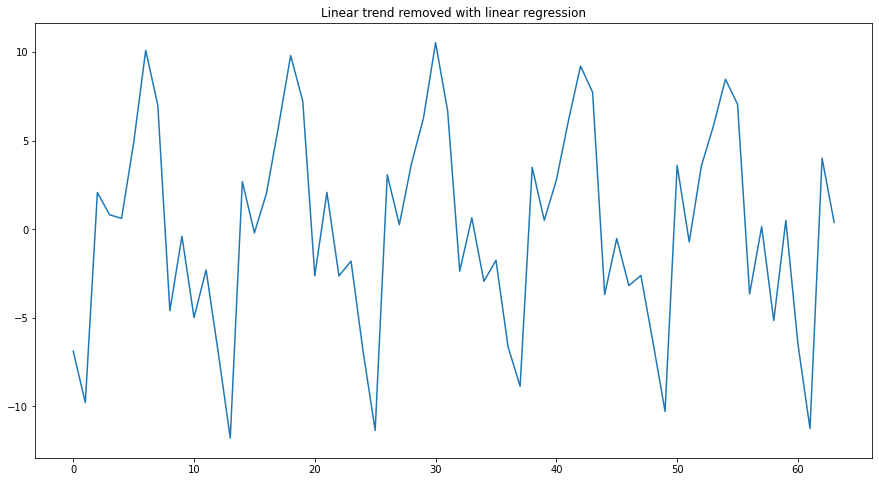

In [6]:
linear_trend = np.array(x) * model.params[1] + model.params[0]
plt.title('Linear trend removed with linear regression')
plt.plot(airline.total.values - linear_trend)

# Remove linear trend with substraction

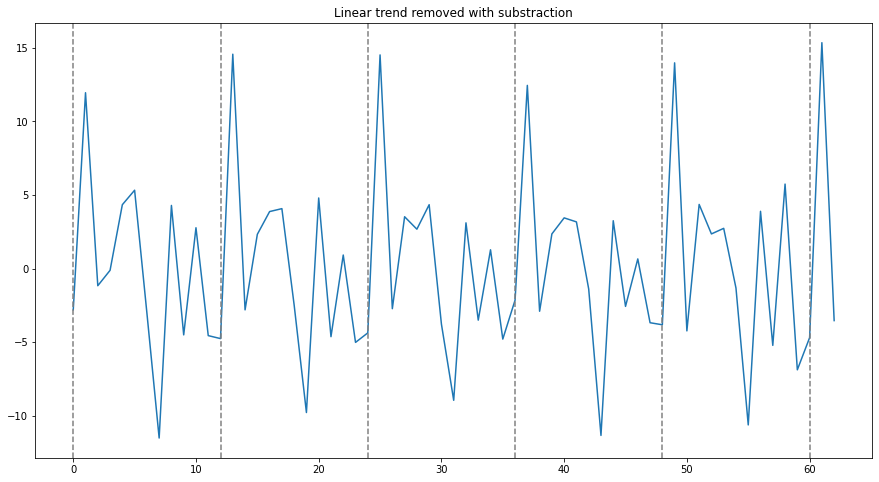

In [7]:
airline_without_trend = airline.total.values[1:] - airline.total.values[0:len(airline)-1]
plt.title('Linear trend removed with substraction')
plt.plot(airline_without_trend)
for i in range(6):
    plt.axvline(i*12, color='grey', linestyle='--')

# Remove seasonality with substraction

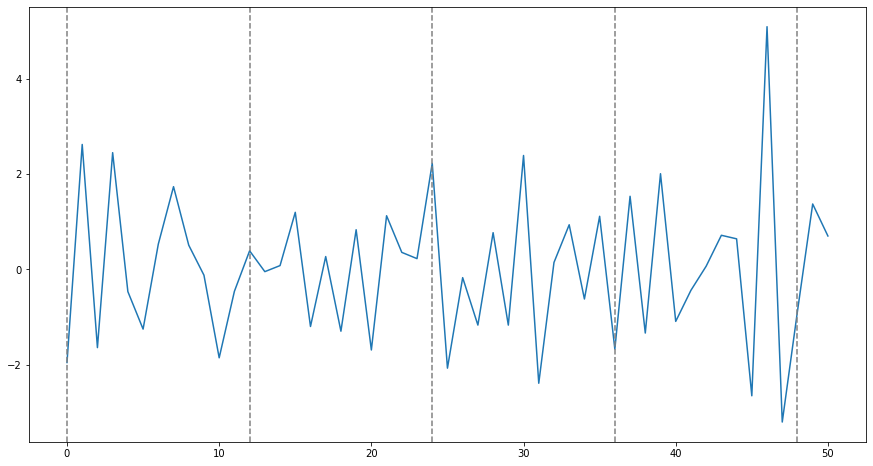

In [8]:
airline_without_trend_without_seasonality = airline_without_trend[12:] - airline_without_trend[0:len(airline)-13]
plt.plot(airline_without_trend_without_seasonality)
for i in range(5):
    plt.axvline(i*12, color='grey', linestyle='--')

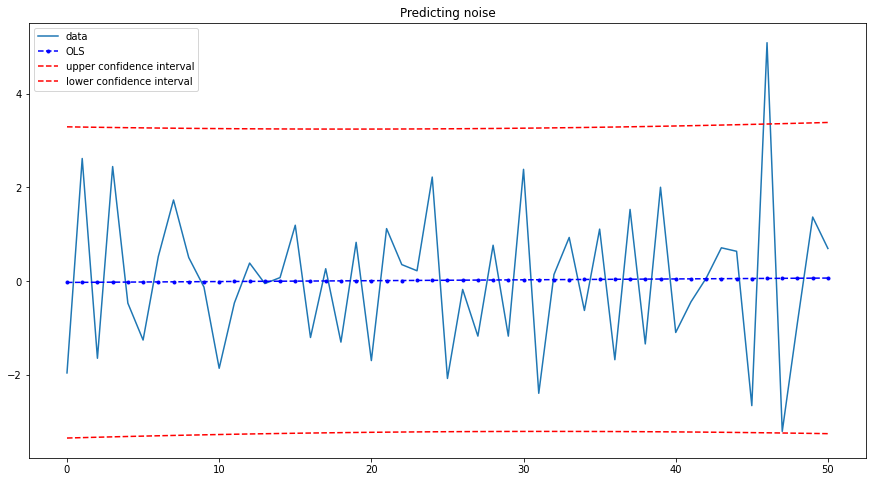

In [9]:
y = airline_without_trend_without_seasonality
x = list(range(len(airline_without_trend_without_seasonality)))
model = sm.OLS(y, sm.add_constant(x)).fit()

prstd, iv_l, iv_u = wls_prediction_std(model)

fig, ax = plt.subplots()
plt.title('Predicting noise')

ax.plot(x, y, label="data")
ax.plot(x, model.fittedvalues, 'b--.', label="OLS")
ax.plot(x, iv_u, 'r--', label="upper confidence interval")
ax.plot(x, iv_l, 'r--', label="lower confidence interval")
ax.legend(loc='best');

# Forecasting with trend and seasonality

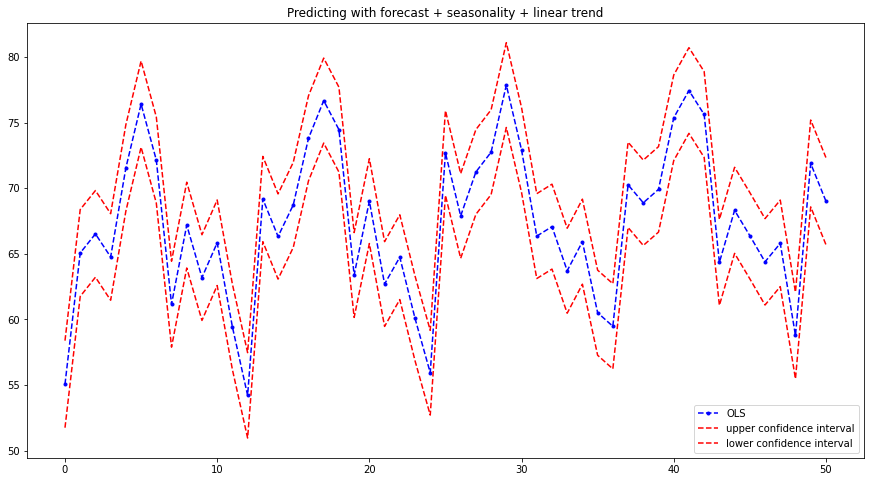

In [10]:
fig, ax = plt.subplots()
plt.title('Predicting with forecast + seasonality + linear trend')
model.fittedvalues = model.fittedvalues + airline.total.values[12:len(airline)-1] + airline_without_trend[0:len(airline)-13] 
iv_u = iv_u + airline.total.values[12:len(airline)-1] + airline_without_trend[0:len(airline)-13]
iv_l = iv_l + airline.total.values[12:len(airline)-1] + airline_without_trend[0:len(airline)-13]
#ax.plot(x, y, label="data")
ax.plot(x, model.fittedvalues, 'b--.', label="OLS")
ax.plot(x, iv_u, 'r--', label="upper confidence interval")
ax.plot(x, iv_l, 'r--', label="lower confidence interval")
ax.legend(loc='best');

# Seasonal ARIMA

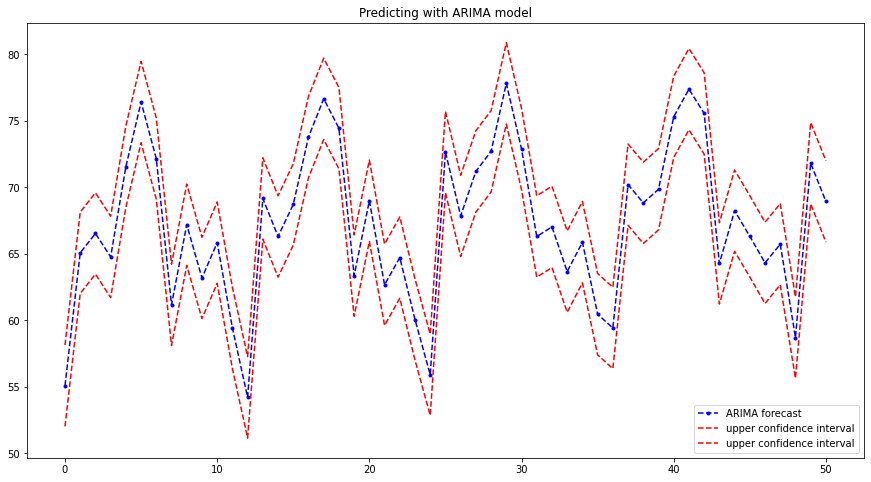

In [11]:
mod = sm.tsa.statespace.SARIMAX(airline.total.values,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12))
fit_res = mod.fit()
res = res = mod.filter(fit_res.params)

predict = res.get_prediction()
predict_ci = predict.conf_int()

fig, ax = plt.subplots()
plt.title('Predicting with ARIMA model')
ax.plot(predict.predicted_mean[13:], 'b--.', label="ARIMA forecast")
ax.plot(predict_ci[13:,0], 'r--', label="upper confidence interval")
ax.plot(predict_ci[13:,1], 'r--', label="upper confidence interval")
ax.legend(loc='best');

# Reference

https://en.wikipedia.org/wiki/Time_series

https://www.bts.dot.gov/

https://en.wikipedia.org/wiki/Simple_linear_regression

https://encyclopediaofmath.org/wiki/Three-sigma_rule

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html